In [1]:
%load_ext autoreload
%autoreload 2

### Graph embedding notebook

Evaluate options for graph embeddings

some useful references:

- https://distill.pub/2021/gnn-intro/
- https://web.stanford.edu/class/cs224w/
- https://pytorch-geometric.readthedocs.io/en/latest/

Structure of the nb:

1) data prep
2) model and training
3) visualization

Next steps:

Train/test split, include Argoverse data

In [2]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
import networkx as nx
import numpy as np
from enum import Enum

import pickle
import networkx as nx
from torch_geometric.nn import GINEConv, global_mean_pool, global_max_pool, global_add_pool

import torch
import torch.nn.functional as F
import os
import glob
import pickle
import numpy as np
from sklearn.model_selection import train_test_split

import torch
import torch.nn.functional as F
from torch_geometric.data import DataLoader
import glob
import pickle
from tqdm import tqdm
from graph_creator.plot_graphs import plot_lane_map_advanced, add_actors_to_map, add_actor_edges_to_map
from graph_creator.MapGraph import MapGraph
import seaborn as sns
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pandas as pd

from graph_creator.graph_embeddings import GraphDataset, TrainableGraphGINE, contrastive_loss, augment_graph, get_feature_dimensions, networkx_to_pyg

### Data prep

In [3]:
graph_paths = glob.glob("/home/tmuehlen/repos/graph_coverage/actor_graphs/carla/*.pkl")
graph_paths = [path for path in graph_paths if "2025-09-05" in path]
print(len(graph_paths))


4442


In [4]:
# add argoverse data
argoverse_graph_paths = glob.glob("/home/tmuehlen/repos/graph_coverage/actor_graphs/argoverse_nx/*.pkl")
graph_paths.extend(argoverse_graph_paths)
print(len(graph_paths))


8030


In [5]:
# Load data
graph_ds = GraphDataset(graph_paths)
train_loader = DataLoader(graph_ds, batch_size=32, shuffle=True)

/home/tmuehlen/.cache/pypoetry/virtualenvs/graph-creator-_1ofKhL9-py3.10/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [ ]:
# set([path.split("/")[-1].split("_")[1] for path in graph_paths])

In [6]:
# try out data loader
graph_ds.__getitem__(4300)
#batch = next(iter(train_loader))

(Data(x=[5, 5], edge_index=[2, 8], edge_attr=[8, 7]),
 '/home/tmuehlen/repos/graph_coverage/actor_graphs/carla/graph_2025-09-05 21:37:47.869390_1_0.pkl')

### Training

In [7]:
# Model setup
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = "cpu"
node_dim, edge_dim = get_feature_dimensions()
model = TrainableGraphGINE(node_dim, edge_dim, 256, 96, 4).to(device)

# Training
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [8]:
# get the pre-training loss
total_loss = 0

with torch.no_grad():
    for batch in train_loader:
        batch = batch[0].to(device)
        aug_batch = augment_graph(batch).to(device)
        outputs1 = model(batch)
        outputs2 = model(aug_batch)
        loss = contrastive_loss(outputs1['projection'], outputs2['projection'])
        total_loss += loss.item()

# if epoch % 1 == 0:
print(f'pre-training loss:: {total_loss/len(train_loader):.4f}')

pre-training loss:: 2.2401


In [9]:
for epoch in range(25):
    total_loss = 0
   
    for batch in train_loader:
        batch = batch[0].to(device)
        aug_batch = augment_graph(batch).to(device)

        optimizer.zero_grad()

        outputs1 = model(batch)
        outputs2 = model(aug_batch)

        loss = contrastive_loss(outputs1['projection'], outputs2['projection'])
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # if epoch % 1 == 0:
    print(f'Epoch {epoch}, Loss: {total_loss/len(train_loader):.4f}')



Epoch 0, Loss: 0.3992
Epoch 1, Loss: 0.2001
Epoch 2, Loss: 0.1701
Epoch 3, Loss: 0.1438
Epoch 4, Loss: 0.1300
Epoch 5, Loss: 0.1275
Epoch 6, Loss: 0.1230
Epoch 7, Loss: 0.1164
Epoch 8, Loss: 0.1070
Epoch 9, Loss: 0.1082
Epoch 10, Loss: 0.1047
Epoch 11, Loss: 0.0992
Epoch 12, Loss: 0.0936
Epoch 13, Loss: 0.1002
Epoch 14, Loss: 0.0909
Epoch 15, Loss: 0.0914
Epoch 16, Loss: 0.0949
Epoch 17, Loss: 0.0854
Epoch 18, Loss: 0.0844
Epoch 19, Loss: 0.0875
Epoch 20, Loss: 0.0827
Epoch 21, Loss: 0.0806
Epoch 22, Loss: 0.0804
Epoch 23, Loss: 0.0787
Epoch 24, Loss: 0.0755


In [10]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
for epoch in range(25):
    total_loss = 0
   
    for batch in train_loader:
        batch = batch[0].to(device)
        aug_batch = augment_graph(batch).to(device)

        optimizer.zero_grad()

        outputs1 = model(batch)
        outputs2 = model(aug_batch)

        loss = contrastive_loss(outputs1['projection'], outputs2['projection'])
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # if epoch % 1 == 0:
    print(f'Epoch {epoch}, Loss: {total_loss/len(train_loader):.4f}')

# Save model
# torch.save(model.state_dict(), 'gine_model.pth')

Epoch 0, Loss: 0.0640
Epoch 1, Loss: 0.0626
Epoch 2, Loss: 0.0615
Epoch 3, Loss: 0.0584
Epoch 4, Loss: 0.0625
Epoch 5, Loss: 0.0562
Epoch 6, Loss: 0.0561
Epoch 7, Loss: 0.0557
Epoch 8, Loss: 0.0568
Epoch 9, Loss: 0.0539
Epoch 10, Loss: 0.0507
Epoch 11, Loss: 0.0494
Epoch 12, Loss: 0.0522
Epoch 13, Loss: 0.0485
Epoch 14, Loss: 0.0517
Epoch 15, Loss: 0.0546
Epoch 16, Loss: 0.0532
Epoch 17, Loss: 0.0516
Epoch 18, Loss: 0.0538
Epoch 19, Loss: 0.0471
Epoch 20, Loss: 0.0470
Epoch 21, Loss: 0.0474
Epoch 22, Loss: 0.0493
Epoch 23, Loss: 0.0450
Epoch 24, Loss: 0.0464


In [11]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
for epoch in range(10):
    total_loss = 0
   
    for batch in train_loader:
        batch = batch[0].to(device)
        aug_batch = augment_graph(batch).to(device)

        optimizer.zero_grad()

        outputs1 = model(batch)
        outputs2 = model(aug_batch)

        loss = contrastive_loss(outputs1['projection'], outputs2['projection'])
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # if epoch % 1 == 0:
    print(f'Epoch {epoch}, Loss: {total_loss/len(train_loader):.4f}')

# Save model
# torch.save(model.state_dict(), 'gine_model.pth')

Epoch 0, Loss: 0.0473
Epoch 1, Loss: 0.0436
Epoch 2, Loss: 0.0426
Epoch 3, Loss: 0.0395
Epoch 4, Loss: 0.0439
Epoch 5, Loss: 0.0412
Epoch 6, Loss: 0.0379
Epoch 7, Loss: 0.0362
Epoch 8, Loss: 0.0414
Epoch 9, Loss: 0.0389


### Inference

In [12]:
# Inference loop
model.eval()
all_embeddings = []
all_paths = []

with torch.no_grad():
   for batch in tqdm(train_loader):  # or test_loader
       all_paths.extend(batch[1]) 
       batch = batch[0].to(device)
       outputs = model(batch)
       embeddings = outputs['embeddings']
       all_embeddings.append(embeddings.cpu())

# Concatenate all embeddings
final_embeddings = torch.cat(all_embeddings, dim=0)
print(f'Extracted {final_embeddings.shape[0]} embeddings of dimension {final_embeddings.shape[1]}')

100%|██████████| 251/251 [00:04<00:00, 56.42it/s]


Extracted 8030 embeddings of dimension 256


In [ ]:
graph_dates = [path.split("/")[-1].split("_")[1] for path in all_paths]
#all_paths


In [48]:
graph_type = [path.split("/")[6] for path in all_paths]

### Visualization of embeddings

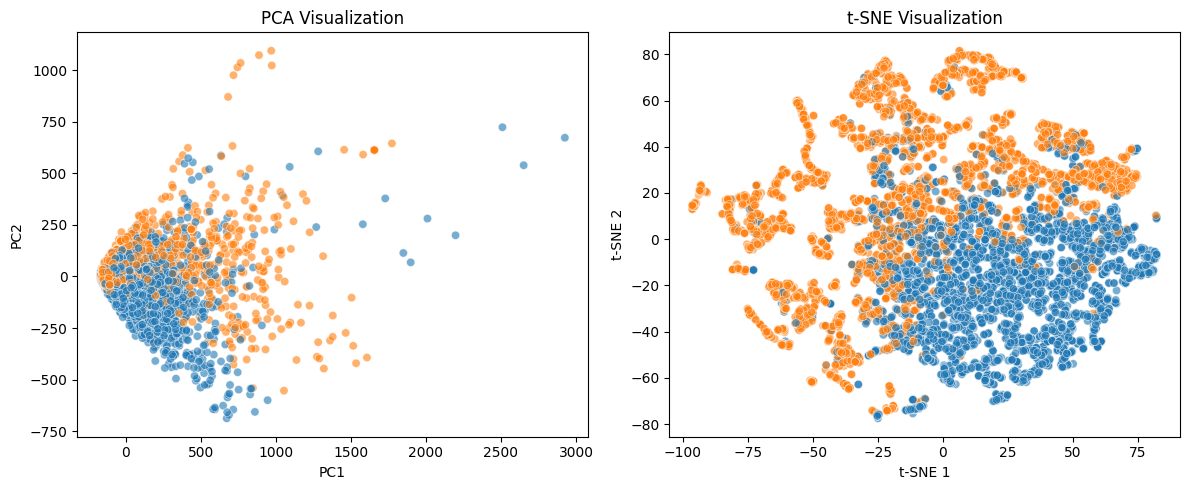

In [20]:

# Convert embeddings to numpy
embeddings_np = final_embeddings.numpy()

# PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings_np)

pca_df = pd.DataFrame(pca_result)
pca_df.columns = ["pca1", "pca2"]
pca_df["graph_type"] = graph_type
pca_df["graph_path"] = all_paths
pca_df.head()

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(x="pca1", y="pca2", alpha=0.6, hue="graph_type", legend = False, data=pca_df)
#plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.6)
plt.title('PCA Visualization')
plt.xlabel('PC1')
plt.ylabel('PC2')

# t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_result = tsne.fit_transform(embeddings_np)
tsne_df = pd.DataFrame(tsne_result)
tsne_df.columns = ["tsne1", "tsne2"]
tsne_df["graph_type"] = graph_type
tsne_df["graph_path"] = all_paths

plt.subplot(1, 2, 2)
# plt.scatter(tsne_result[:, 0], tsne_result[:, 1], alpha=0.6)
sns.scatterplot(x="tsne1", y="tsne2", alpha=0.6, hue="graph_type", legend = False, data=tsne_df)
plt.title('t-SNE Visualization')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')

plt.tight_layout()
plt.show()

In [15]:
os.getcwd()
os.chdir("../..")
os.getcwd()

'/home/tmuehlen/repos/graph_coverage'

In [ ]:
embeddings_np.shape

In [ ]:
pca_df.graph_path

,pca1,pca2,timestamp,graph_path,dist
1015,238.526215,141.089066,argoverse_nx,/home/tmuehlen/repos/graph_coverage/actor_grap...,0.000000e+00
6123,237.080170,131.602081,carla,/home/tmuehlen/repos/graph_coverage/actor_grap...,9.209392e+01
6171,248.091858,153.693573,carla,/home/tmuehlen/repos/graph_coverage/actor_grap...,2.503752e+02
8014,241.605774,123.916679,carla,/home/tmuehlen/repos/graph_coverage/actor_grap...,3.043745e+02
7513,245.679657,117.202049,argoverse_nx,/home/tmuehlen/repos/graph_coverage/actor_grap...,6.217613e+02
...,...,...,...,...,...
6729,2010.836426,280.791504,argoverse_nx,/home/tmuehlen/repos/graph_coverage/actor_grap...,3.160600e+06
306,2198.028076,199.768402,argoverse_nx,/home/tmuehlen/repos/graph_coverage/actor_grap...,3.843091e+06
7578,2510.298096,723.683105,argoverse_nx,/home/tmuehlen/repos/graph_coverage/actor_grap...,5.500364e+06
5319,2651.808350,539.283203,argoverse_nx,/home/tmuehlen/repos/graph_coverage/actor_grap...,5.982490e+06


In [26]:
mask_carla = pca_df.graph_type == "carla"
mask_argo = pca_df.graph_type == "argoverse_nx"
pca_carla_df = pca_df[mask_carla].reset_index(drop=True)
pca_argo_df = pca_df[mask_argo].reset_index(drop=True)


In [ ]:
g_map = MapGraph()

g_map.read_graph_from_file(f'/home/tmuehlen/repos/graph_coverage/data/argoversion_actor_and_map/{scn_1}_map_graph.pkl')
dir(g_map.graph.graph)

#fig, ax1 = plot_lane_map_advanced(g_map.graph.graph, figsize=None, color_by_length=True, cmap='plasma', show_labels=False, fig = fig, ax = ax1)


<Figure size 640x480 with 0 Axes>

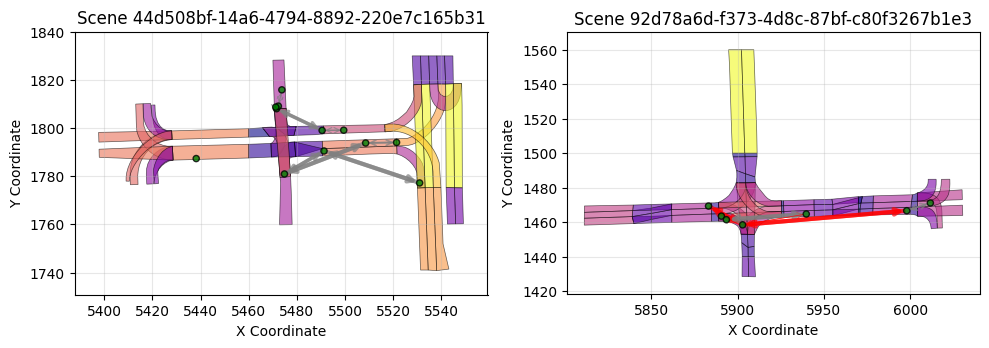

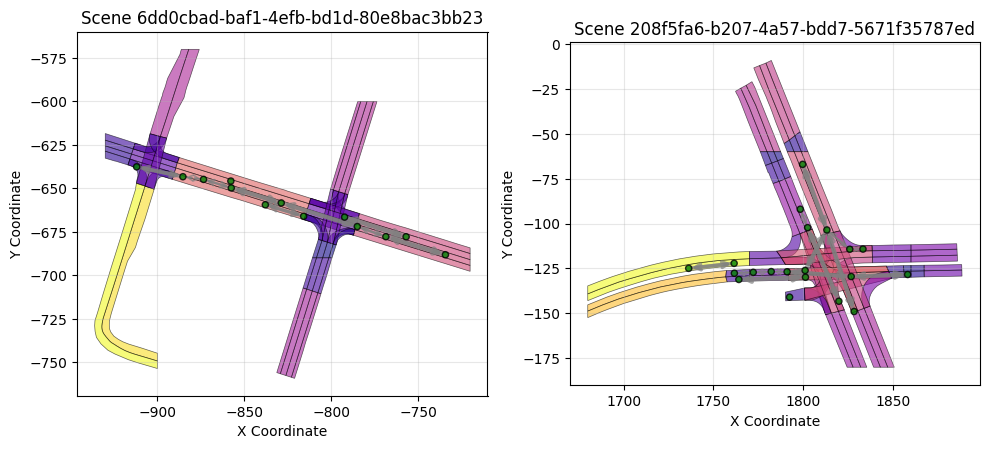

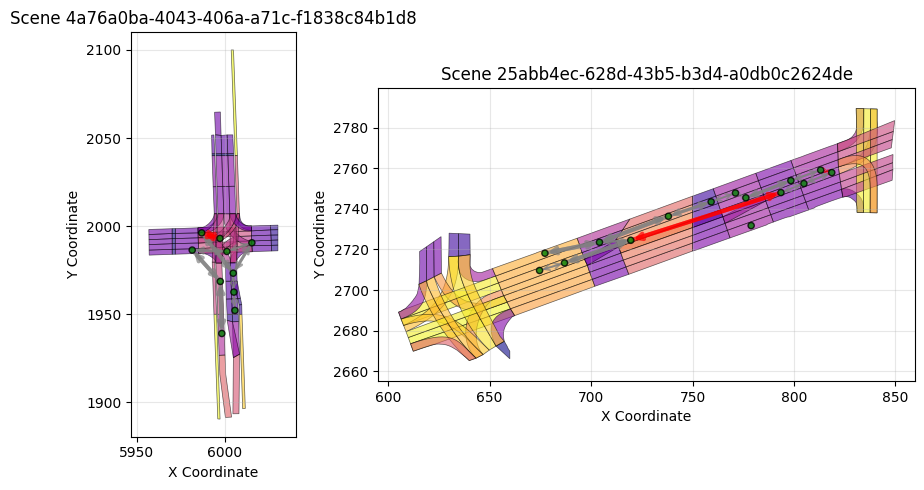

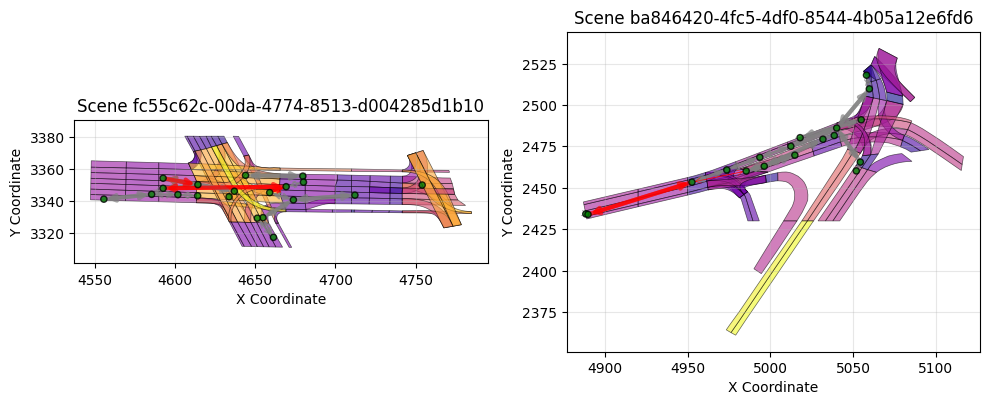

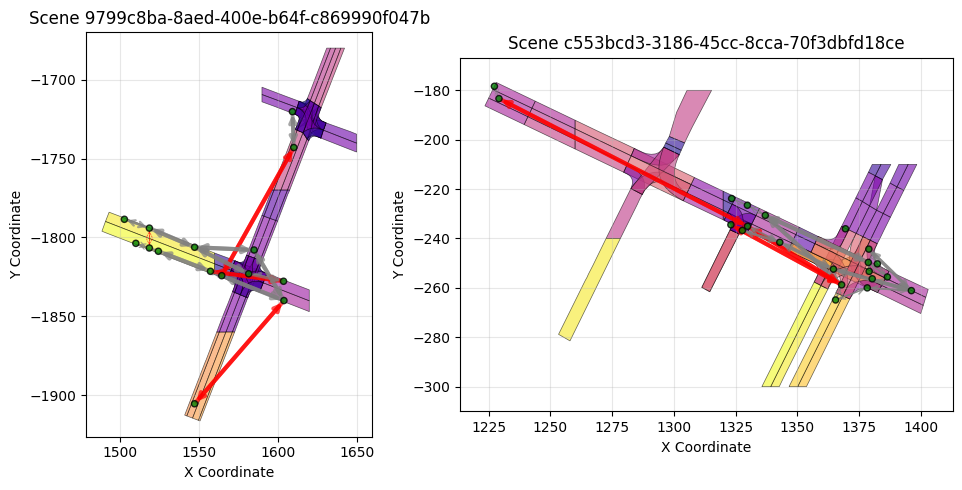

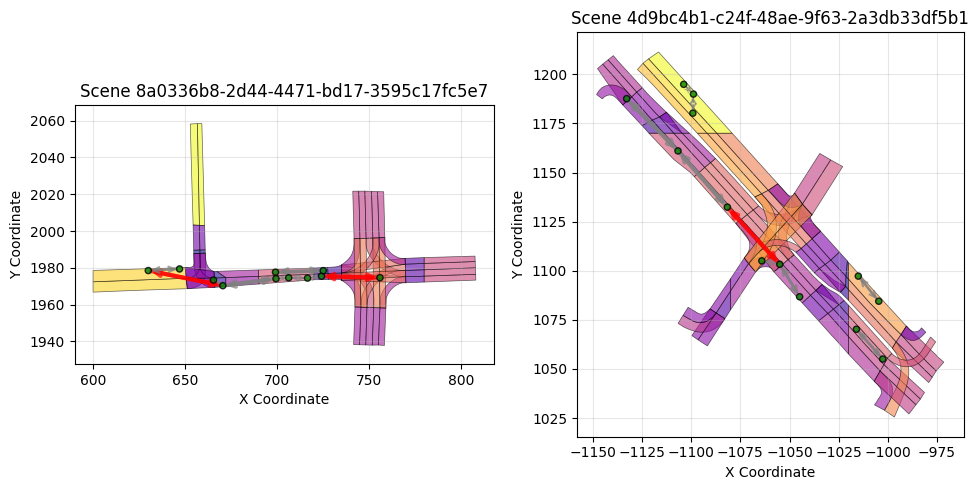

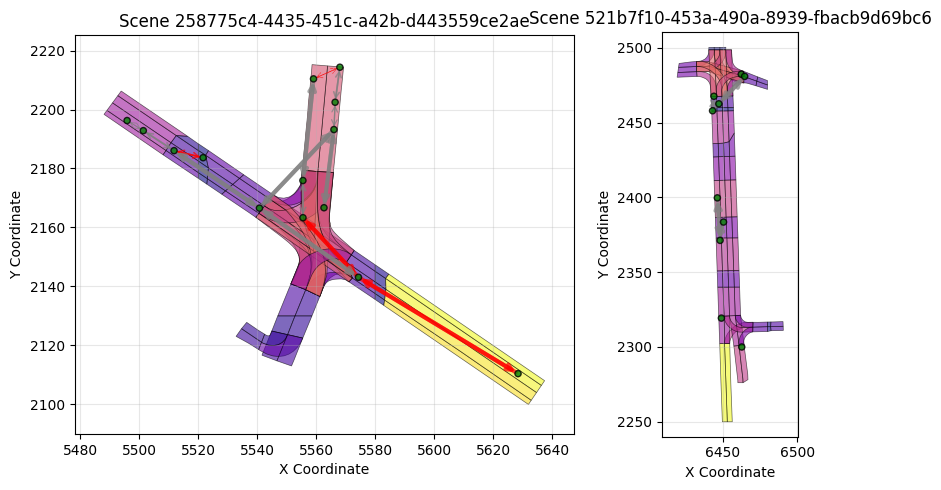

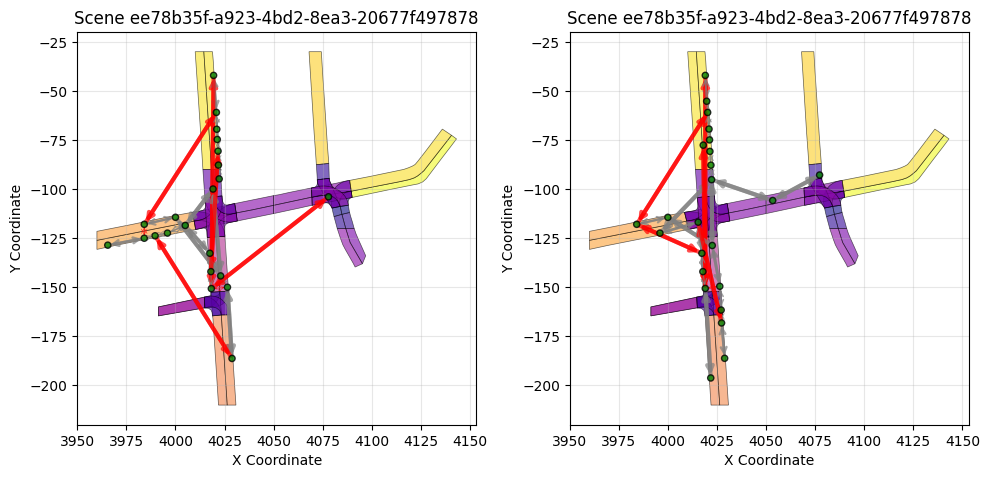

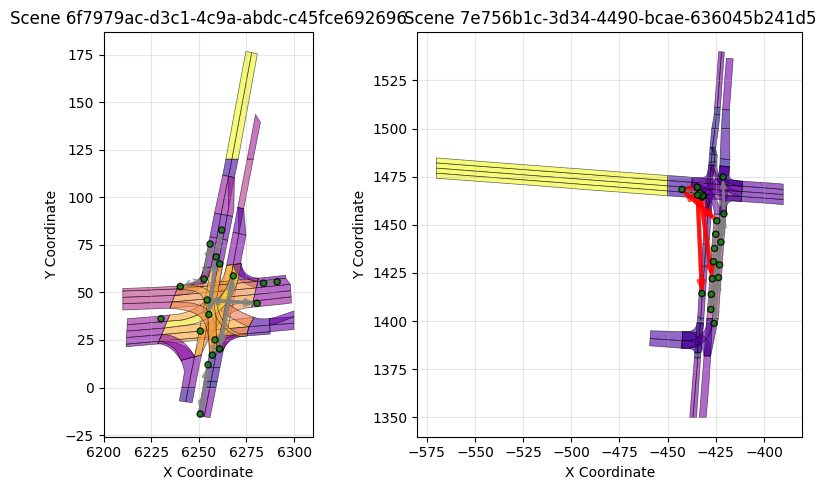

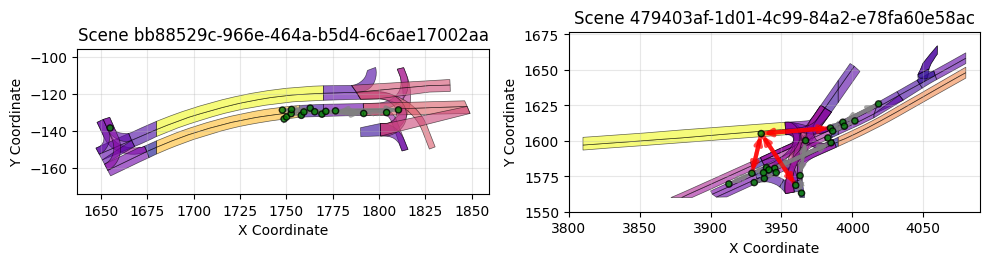

In [46]:
# # wait for map graphs to arrive from Marius
for i in range(10):
    try:
        first = pca_argo_df.sample(1)
        pca_argo_df["dist"] = (pca_argo_df.pca1 - first.pca1.iloc[0])**2 + (pca_argo_df.pca2 - first.pca2.iloc[0])**2 
        pca_argo_df.sort_values("dist", inplace=True)
        graph_1 = pca_argo_df.graph_path.iloc[0].split("/")[-1].split(".pkl")[0].split("graph_")[1]
        graph_2 = pca_argo_df.graph_path.iloc[1].split("/")[-1].split(".pkl")[0].split("graph_")[1]
        scn_1 = graph_1[:36]
        scn_2 = graph_2[:36]
        file_path_1 = f"/home/tmuehlen/repos/graph_coverage/actor_graphs/argoverse_nx/graph_{graph_1}.pkl"
        with open(file_path_1, 'rb') as f:
            nx_graph_1 = pickle.load(f)
        file_path_2 = f"/home/tmuehlen/repos/graph_coverage/actor_graphs/argoverse_nx/graph_{graph_2}.pkl"
        with open(file_path_2, 'rb') as f:
            nx_graph_2 = pickle.load(f)
        # # Create figure with two subplots side by side
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
        # First scene (left subplot)
        g_map = MapGraph()
        # "/home/tmuehlen/repos/graph_coverage/data/argoversion_actor_and_map/000ace8b-a3d2-4228-bd87-91b66a9c5127_map_graph.pkl"
        g_map.read_graph_from_file(f'/home/tmuehlen/repos/graph_coverage/data/argoversion_actor_and_map/{scn_1}_map_graph.pkl')
        fig, ax1 = plot_lane_map_advanced(g_map.graph.graph, figsize=None, color_by_length=True, cmap='plasma', show_labels=False, fig = fig, ax = ax1)
        fig, ax1 = add_actors_to_map(fig, ax1, nx_graph_1, actor_size=20, show_actor_labels=False)
        fig, ax1 = add_actor_edges_to_map(fig, ax1, nx_graph_1)
        ax1.set_title(f'Scene {scn_1}')
        # Second scene (right subplot)
        g_map = MapGraph()
        g_map.read_graph_from_file(f'/home/tmuehlen/repos/graph_coverage/data/argoversion_actor_and_map/{scn_2}_map_graph.pkl')
        fig, ax2 = plot_lane_map_advanced(g_map.graph.graph, figsize=None, color_by_length=True, cmap='plasma', show_labels=False, fig = fig, ax = ax2)
        fig, ax2 = add_actors_to_map(fig, ax2, nx_graph_2, actor_size=20, show_actor_labels=False)
        fig, ax2 = add_actor_edges_to_map(fig, ax2, nx_graph_2)
        ax2.set_title(f'Scene {scn_2}')
        # Adjust layout and display
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error processing scene {scn_1} and {scn_2}: {e}")


2025-09-05 22:12:16.686079_0_0 2025-09-05 22:12:16.686079
2025-09-05 21:37:47.869390_0_2 2025-09-05 21:37:47.869390


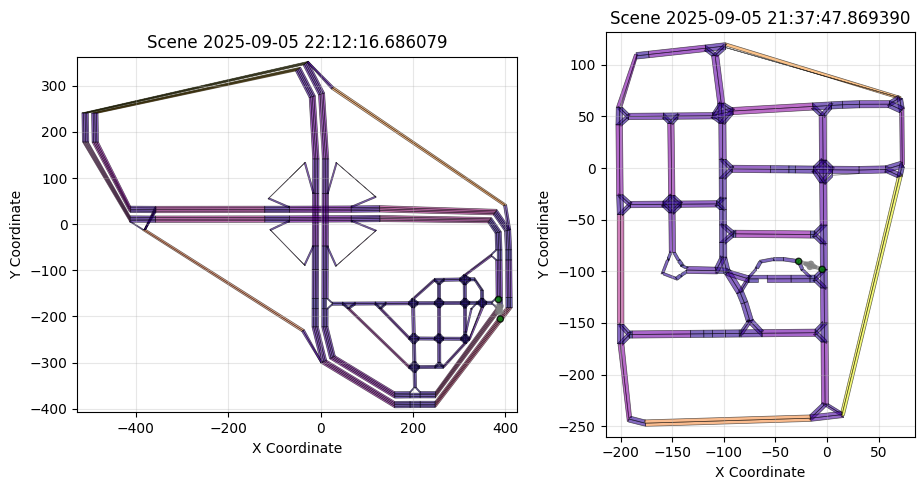

2025-09-05 21:26:57.714374_3_5 2025-09-05 21:26:57.714374
2025-09-05 22:22:06.379117_14_3 2025-09-05 22:22:06.379117


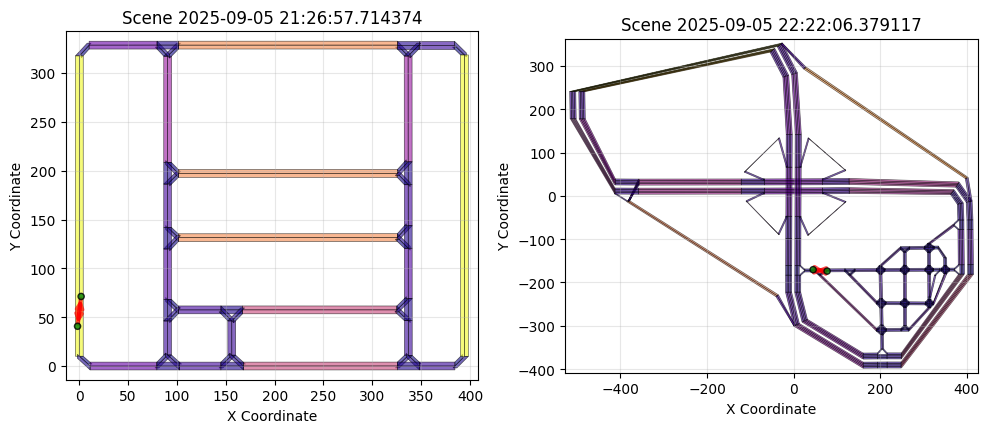

2025-09-05 21:29:22.491682_8_3 2025-09-05 21:29:22.491682
2025-09-05 23:13:32.712950_1_4 2025-09-05 23:13:32.712950


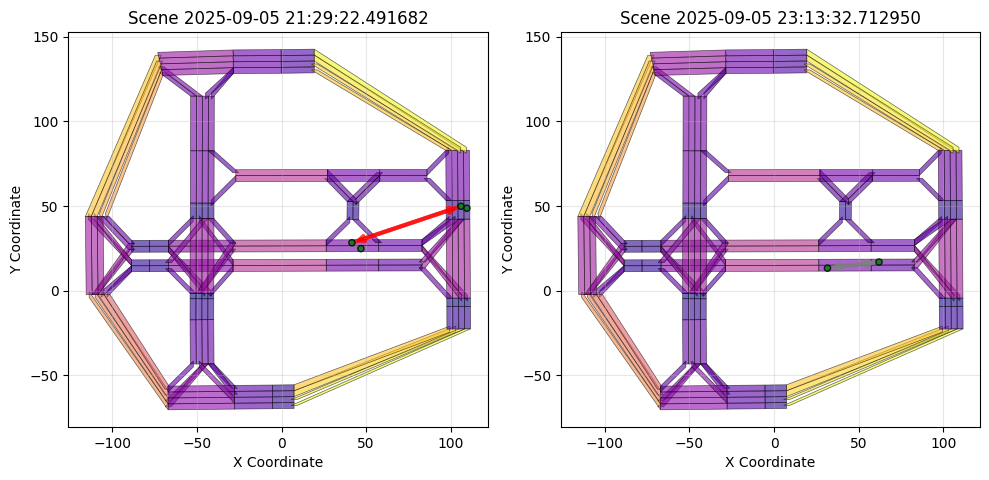

2025-09-05 21:37:47.869390_11_1 2025-09-05 21:37:47.869390
2025-09-05 21:37:47.869390_2_3 2025-09-05 21:37:47.869390


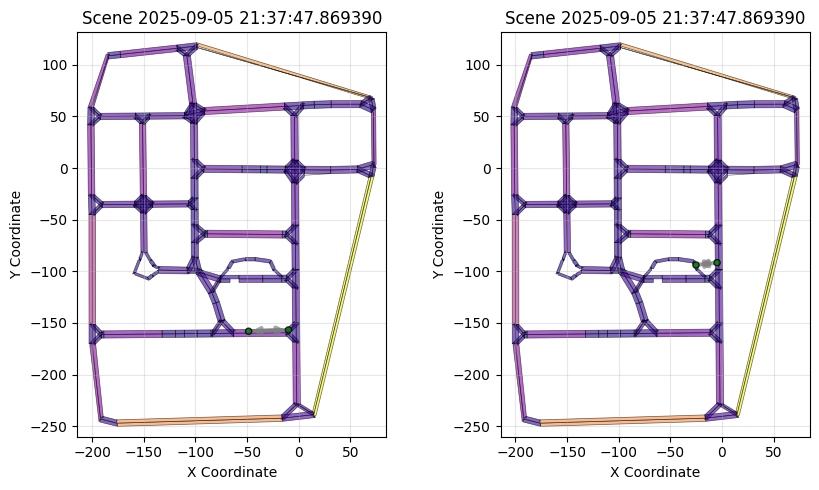

2025-09-05 21:53:15.983992_14_0 2025-09-05 21:53:15.983992
2025-09-05 22:04:02.804969_7_3 2025-09-05 22:04:02.804969


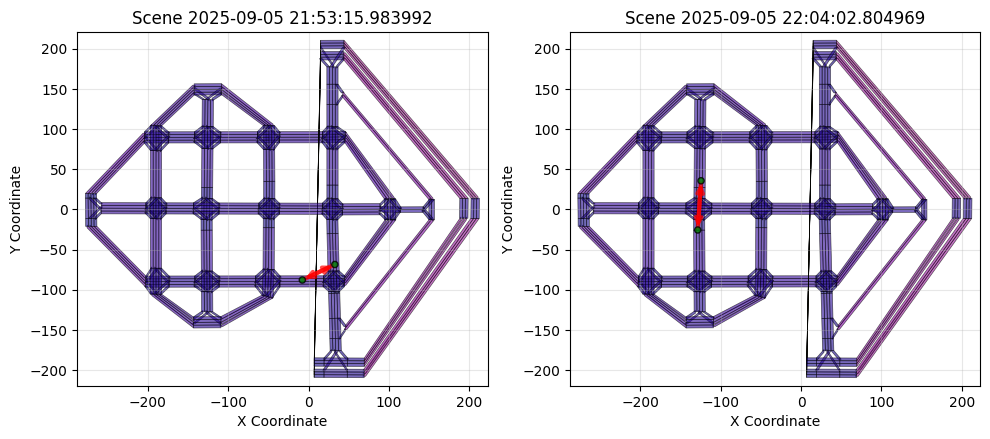

2025-09-05 23:02:51.286506_8_0 2025-09-05 23:02:51.286506
2025-09-05 21:23:45.684656_2_0 2025-09-05 21:23:45.684656


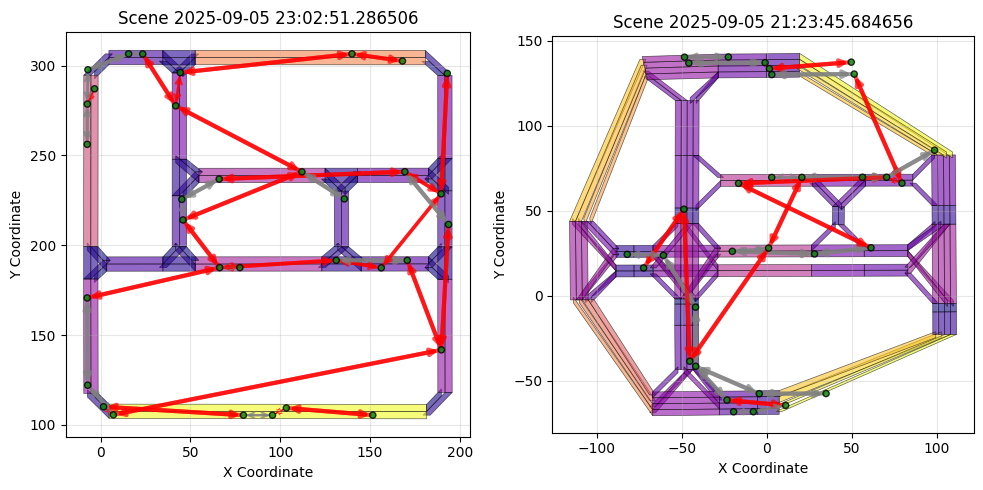

2025-09-05 21:34:48.103135_9_2 2025-09-05 21:34:48.103135
2025-09-05 23:03:44.754618_2_0 2025-09-05 23:03:44.754618
Error processing scene 2025-09-05 21:34:48.103135 and 2025-09-05 23:03:44.754618: 'node_info'
2025-09-05 23:13:32.712950_7_2 2025-09-05 23:13:32.712950
2025-09-05 21:31:09.129197_15_1 2025-09-05 21:31:09.129197


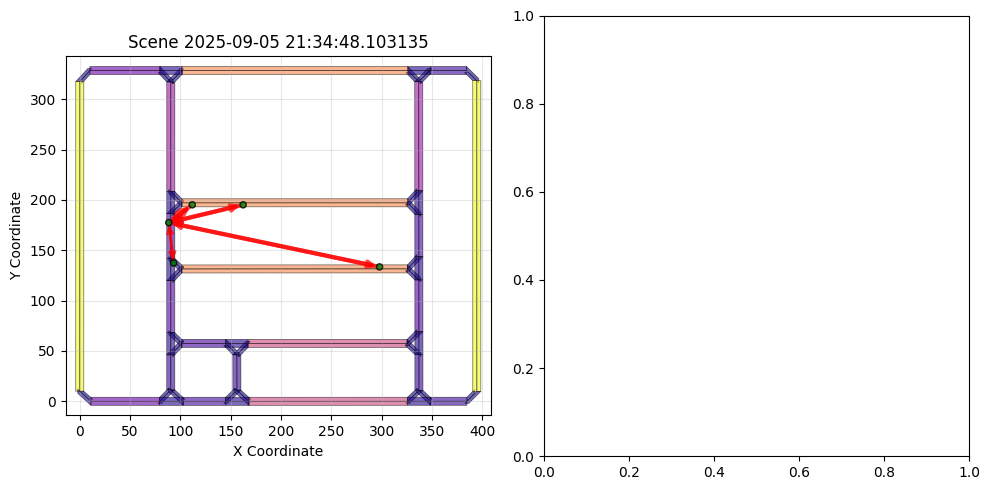

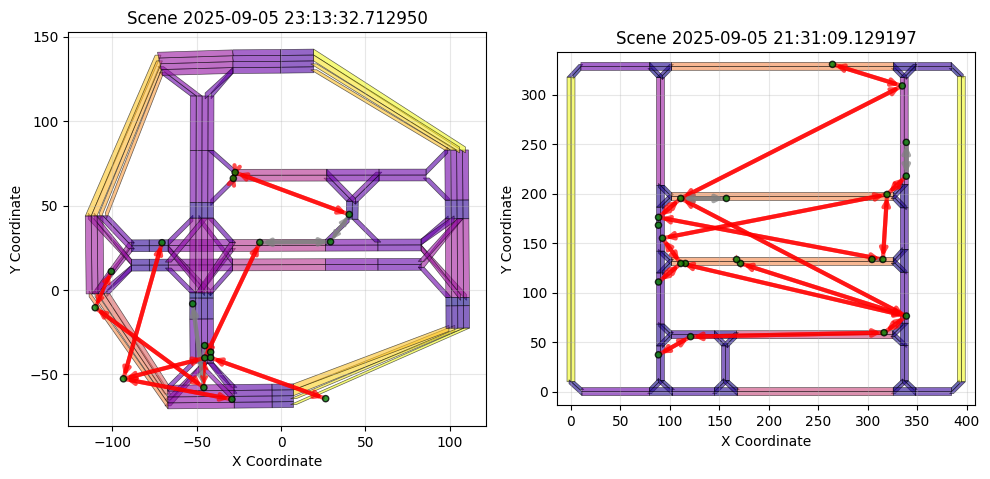

2025-09-05 22:13:08.384263_0_2 2025-09-05 22:13:08.384263
2025-09-05 21:54:20.727514_12_3 2025-09-05 21:54:20.727514


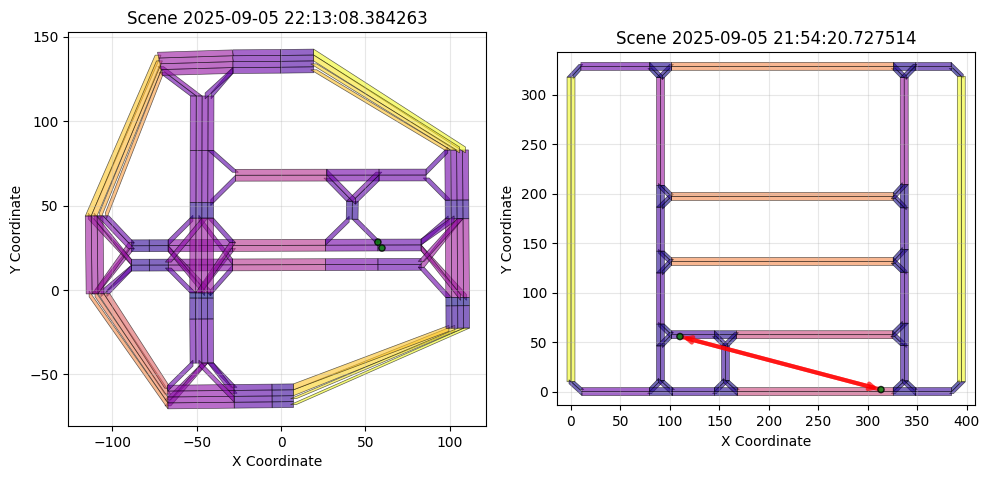

2025-09-05 21:25:35.167988_6_3 2025-09-05 21:25:35.167988
2025-09-05 21:24:17.725796_14_2 2025-09-05 21:24:17.725796


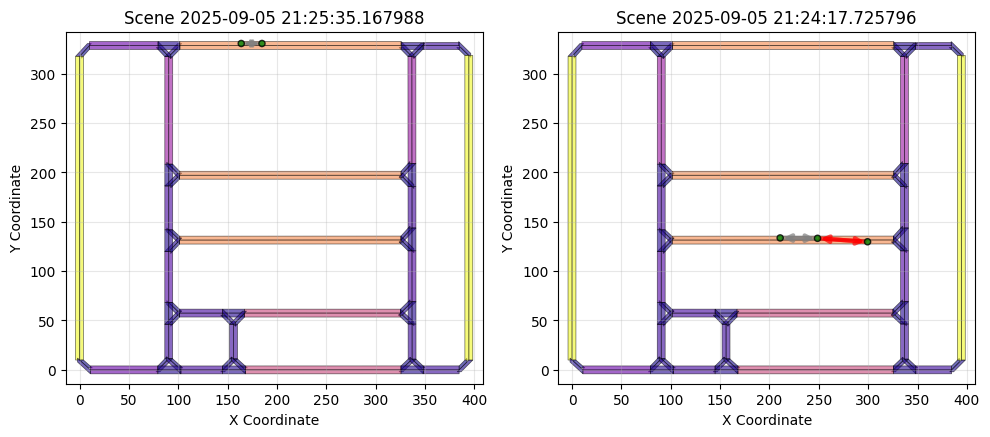

In [47]:
for i in range(10):
    try:
        first = pca_carla_df.sample(1)
        pca_carla_df["dist"] = (pca_carla_df.pca1 - first.pca1.iloc[0])**2 + (pca_carla_df.pca2 - first.pca2.iloc[0])**2 
        pca_carla_df.sort_values("dist", inplace=True)
        #print(pca_df.graph_path.iloc[0])
        #print(pca_df.graph_path.iloc[1])
        graph_1 = pca_carla_df.graph_path.iloc[0].split("/")[-1].split(".pkl")[0].split("graph_")[1]
        graph_2 = pca_carla_df.graph_path.iloc[1].split("/")[-1].split(".pkl")[0].split("graph_")[1]
        scn_1 = graph_1[:26]
        scn_2 = graph_2[:26]
        print(graph_1, scn_1)
        print(graph_2, scn_2)
        pca_df.head(2)
        file_path_1 = f"/home/tmuehlen/repos/graph_coverage/actor_graphs/carla/graph_{graph_1}.pkl"
        with open(file_path_1, 'rb') as f:
            nx_graph_1 = pickle.load(f)
        file_path_2 = f"/home/tmuehlen/repos/graph_coverage/actor_graphs/carla/graph_{graph_2}.pkl"
        with open(file_path_2, 'rb') as f:
            nx_graph_2 = pickle.load(f)
        # Create figure with two subplots side by side
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
        # First scene (left subplot)
        g_map = MapGraph()
        g_map.read_graph_from_file(f'/home/tmuehlen/repos/graph_coverage/carla/data/scene_{scn_1}_map_graph.pickle')
        fig, ax1 = plot_lane_map_advanced(g_map.graph, figsize=None, color_by_length=True, cmap='plasma', show_labels=False, fig = fig, ax = ax1)
        fig, ax1 = add_actors_to_map(fig, ax1, nx_graph_1, actor_size=20, show_actor_labels=False)
        fig, ax1 = add_actor_edges_to_map(fig, ax1, nx_graph_1)
        ax1.set_title(f'Scene {scn_1}')
        # Second scene (right subplot)
        g_map = MapGraph()
        g_map.read_graph_from_file(f'/home/tmuehlen/repos/graph_coverage/carla/data/scene_{scn_2}_map_graph.pickle')
        fig, ax2 = plot_lane_map_advanced(g_map.graph, figsize=None, color_by_length=True, cmap='plasma', show_labels=False, fig = fig, ax = ax2)
        fig, ax2 = add_actors_to_map(fig, ax2, nx_graph_2, actor_size=20, show_actor_labels=False)
        fig, ax2 = add_actor_edges_to_map(fig, ax2, nx_graph_2)
        ax2.set_title(f'Scene {scn_2}')
        # Adjust layout and display
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error processing scene {scn_1} and {scn_2}: {e}")


# Notebook junkyard

In [ ]:

# Define mappings for one-hot encodings
ACTOR_TYPE_MAPPING = {
    'VEHICLE': 0,
    'PEDESTRIAN': 1,
    'CYCLIST': 2,
    'MOTORCYCLE': 3,
    # Add more types as needed
}

EDGE_TYPE_MAPPING = {
    'neighbor_vehicle': 0,
    'opposite_vehicle': 1,
    'same_lane': 2,
    'adjacent_lane': 3,
    'following': 4,
    'intersection': 5,
    # Add more edge types as needed
}

In [ ]:
from torch.utils.data import Dataset

# Helper function to get feature dimensions
def get_feature_dimensions(actor_type_mapping=None, edge_type_mapping=None):
    """Get the dimensions of node and edge features"""
    if actor_type_mapping is None:
        actor_type_mapping = ACTOR_TYPE_MAPPING
    if edge_type_mapping is None:
        edge_type_mapping = EDGE_TYPE_MAPPING
    
    # Node features: 1 (lon_speed) + num_actor_types (one-hot)
    node_features = 1 + len(actor_type_mapping)
    
    # Edge features: 1 (path_length) + num_edge_types (one-hot)
    edge_features = 1 + len(edge_type_mapping)
    
    return node_features, edge_features

def networkx_to_pyg(nx_graph, actor_type_mapping=None, edge_type_mapping=None):
    """
    Convert NetworkX graph to PyTorch Geometric Data object.
    
    Args:
        nx_graph: NetworkX graph with node and edge attributes
        actor_type_mapping: Dict mapping actor types to indices
        edge_type_mapping: Dict mapping edge types to indices
    
    Returns:
        PyTorch Geometric Data object
    """
    
    # Use default mappings if none provided
    if actor_type_mapping is None:
        actor_type_mapping = ACTOR_TYPE_MAPPING
    if edge_type_mapping is None:
        edge_type_mapping = EDGE_TYPE_MAPPING
    
    # Get node mapping (NetworkX nodes might not be sequential integers)
    nodes = list(nx_graph.nodes())
    node_mapping = {node: idx for idx, node in enumerate(nodes)}
    num_nodes = len(nodes)
    
    # Extract node features
    node_features = []
    for node in nodes:
        node_data = nx_graph.nodes[node]
        
        # Extract lon_speed (continuous feature)
        lon_speed = node_data.get('lon_speed', 0.0)
        
        # Extract actor_type and convert to one-hot
        actor_type = node_data.get('actor_type')
        if hasattr(actor_type, 'value'):  # Handle enum
            actor_type_str = actor_type.value
        else:
            actor_type_str = str(actor_type)
        
        # Get actor type index
        actor_type_idx = actor_type_mapping.get(actor_type_str, 0)  # Default to 0 if unknown
        
        # Create one-hot encoding for actor type
        num_actor_types = len(actor_type_mapping)
        actor_onehot = [0.0] * num_actor_types
        actor_onehot[actor_type_idx] = 1.0
        
        # Combine features: [lon_speed, actor_type_onehot...]
        node_feature = [lon_speed] + actor_onehot
        node_features.append(node_feature)
    
    # Convert to tensor
    x = torch.tensor(node_features, dtype=torch.float)
    
    # Extract edges and edge features
    edge_index = []
    edge_features = []
    
    for source, target, edge_data in nx_graph.edges(data=True):
        # Map node IDs to indices
        source_idx = node_mapping[source]
        target_idx = node_mapping[target]
        
        edge_index.append([source_idx, target_idx])
        
        # Extract path_length (continuous feature)
        path_length = edge_data.get('path_length', 0.0)
        
        # Extract edge_type and convert to one-hot
        edge_type = edge_data.get('edge_type', 'unknown')
        edge_type_idx = edge_type_mapping.get(edge_type, 0)  # Default to 0 if unknown
        
        # Create one-hot encoding for edge type
        num_edge_types = len(edge_type_mapping)
        edge_onehot = [0.0] * num_edge_types
        edge_onehot[edge_type_idx] = 1.0
        
        # Combine features: [path_length, edge_type_onehot...]
        edge_feature = [path_length] + edge_onehot
        edge_features.append(edge_feature)
    
    # Convert to tensors
    if len(edge_index) > 0:
        edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
        edge_attr = torch.tensor(edge_features, dtype=torch.float)
    else:
        # Handle graphs with no edges
        edge_index = torch.empty((2, 0), dtype=torch.long)
        edge_attr = torch.empty((0, 1 + len(edge_type_mapping)), dtype=torch.float)
    
    # Create PyG Data object
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
    
    return data



class GraphDataset(Dataset):
    def __init__(self, graph_paths):
        self.graph_paths = graph_paths
        
    def __len__(self):
        return len(self.graph_paths)
    
    def __getitem__(self, idx):
        file_path = self.graph_paths[idx]
        with open(file_path, 'rb') as f:
            nx_graph = pickle.load(f)
        pyg_data = networkx_to_pyg(nx_graph)
        return pyg_data, file_path


In [ ]:
# Enhanced model with training capabilities
class TrainableGraphGINE(torch.nn.Module):
    def __init__(self, node_features, edge_features, embedding_dim=128, hidden_dim=64, num_layers=3, num_classes=None):
        """
        GINE model for graph-level embeddings with optional classification
        
        Args:
            node_features: Number of node features
            edge_features: Number of edge features  
            embedding_dim: Final embedding dimension
            hidden_dim: Hidden layer dimension
            num_layers: Number of GINE layers
            num_classes: Number of classes for supervised learning (None for unsupervised)
        """
        super().__init__()
        
        self.num_layers = num_layers
        self.embedding_dim = embedding_dim
        self.num_classes = num_classes
        
        # GINE layers
        self.convs = torch.nn.ModuleList()
        self.batch_norms = torch.nn.ModuleList()
        
        # First layer
        self.convs.append(
            GINEConv(
                torch.nn.Sequential(
                    torch.nn.Linear(node_features, hidden_dim),
                    torch.nn.BatchNorm1d(hidden_dim),
                    torch.nn.ReLU(),
                    torch.nn.Linear(hidden_dim, hidden_dim)
                ),
                edge_dim=edge_features
            )
        )
        self.batch_norms.append(torch.nn.BatchNorm1d(hidden_dim))
        
        # Hidden layers
        for _ in range(num_layers - 1):
            self.convs.append(
                GINEConv(
                    torch.nn.Sequential(
                        torch.nn.Linear(hidden_dim, hidden_dim),
                        torch.nn.BatchNorm1d(hidden_dim),
                        torch.nn.ReLU(),
                        torch.nn.Linear(hidden_dim, hidden_dim)
                    ),
                    edge_dim=edge_features
                )
            )
            self.batch_norms.append(torch.nn.BatchNorm1d(hidden_dim))
        
        # Graph-level pooling and embedding projection
        self.embedding_proj = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim * 3, embedding_dim),  # *3 for mean+max+sum pooling
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),
            torch.nn.Linear(embedding_dim, embedding_dim)
        )
        
        # Projection head for contrastive learning (unsupervised)
        self.projection_head = torch.nn.Sequential(
            torch.nn.Linear(embedding_dim, embedding_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(embedding_dim, embedding_dim // 2)
        )
        
        # Classification head (supervised)
        if num_classes is not None:
            self.classifier = torch.nn.Sequential(
                torch.nn.Dropout(0.3),
                torch.nn.Linear(embedding_dim, num_classes)
            )
        
    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch
        
        # Handle empty edge attributes
        if edge_attr.size(0) == 0:
            edge_attr = None
        
        # GINE layers
        for i, (conv, bn) in enumerate(zip(self.convs, self.batch_norms)):
            x = conv(x, edge_index, edge_attr)
            x = bn(x)
            x = F.relu(x)
            x = F.dropout(x, p=0.2, training=self.training)
        
        # Graph-level pooling
        mean_pool = global_mean_pool(x, batch)
        max_pool = global_max_pool(x, batch)
        sum_pool = global_add_pool(x, batch)
        
        # Concatenate pooling strategies
        graph_repr = torch.cat([mean_pool, max_pool, sum_pool], dim=1)
        
        # Final embedding
        embeddings = self.embedding_proj(graph_repr)
        
        outputs = {'embeddings': embeddings}
        
        # Add projection for contrastive learning
        outputs['projection'] = self.projection_head(embeddings)
        
        # Add classification if applicable
        if hasattr(self, 'classifier'):
            outputs['logits'] = self.classifier(embeddings)
        
        return outputs
    
    def get_embedding(self, data):
        """Extract embeddings only"""
        self.eval()
        with torch.no_grad():
            outputs = self.forward(data)
            return outputs['embeddings']


In [ ]:
# Contrastive loss
def contrastive_loss(z1, z2, temperature=0.1):
    """InfoNCE contrastive loss"""
    batch_size = z1.size(0)
    z1 = F.normalize(z1, dim=1)
    z2 = F.normalize(z2, dim=1)
    
    # Compute similarity matrix
    sim_matrix = torch.mm(z1, z2.t()) / temperature
    
    # Labels for positive pairs (diagonal)
    labels = torch.arange(batch_size, device=z1.device)
    
    return F.cross_entropy(sim_matrix, labels)

# Data augmentation for contrastive learning
def augment_graph(data):
    """Simple graph augmentation"""
    augmented_data = data.clone()
    
    # Add noise to continuous features
    # Node features: first feature is lon_speed
    if augmented_data.x.size(1) > 0:
        augmented_data.x[:, 0] += torch.randn_like(augmented_data.x[:, 0]) * 0.1
    
    # Edge features: first feature is path_length
    if augmented_data.edge_attr.size(0) > 0 and augmented_data.edge_attr.size(1) > 0:
        augmented_data.edge_attr[:, 0] += torch.randn_like(augmented_data.edge_attr[:, 0]) * 0.1
    
    return augmented_data

